# Taher Muhammedali - 0478012

## Assignment 3 - Task 2 - Data Science ESM

In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### (a)

In [8]:
# Importing the CSVs in two dataframes
ab = 'https://tubcloud.tu-berlin.de/s/P9qPttqFg3ciKEy/download/powerplants.csv'
cd = 'https://tubcloud.tu-berlin.de/s/XjtnxyNPtPP6eDQ/download/technologies.csv'
plantdf = pd.read_csv(ab, index_col=0)
techdf = pd.read_csv(cd)

In [9]:
techdf = techdf.rename({'Carrier': 'carrier'}, axis=1)
techdf = techdf.drop(10) # Removing geothermal from technologies because there are no geothermal powerplants
techdf = techdf.reset_index(drop=True)
plantdf = plantdf.sort_index(ascending=True)

### (b)

In [10]:
# Creating a groupby on carrier and summing on total capacity (p_now)
combineddf = plantdf.copy()
combineddf = combineddf.groupby('carrier').p_nom.sum()
combineddf = combineddf.reset_index(level=0)
combineddf = pd.merge(left=combineddf, right=techdf, on='carrier')
combineddf

,carrier,p_nom,co2_emissions,color
0,CCGT,18468.029000,0.20,#b20101
1,OCGT,3995.732500,0.20,#d35050
2,biomass,8004.647826,0.00,#0c6013
3,coal,14829.727277,0.34,#707070
4,hydro reservoir,169.500000,0.00,#08ad97
5,lignite,21375.403267,0.41,#9e5a01
6,nuclear,5468.000000,0.00,#ff9000
7,offshore wind,7747.000000,0.00,#74c6f2
8,oil,974.700000,0.27,#262626
9,onshore wind,54383.220090,0.00,#235ebc


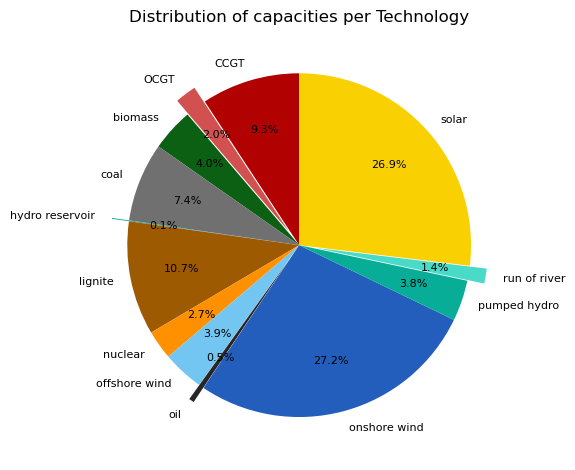

In [11]:
# Creating a pie chart using the df vreated above
explode = [0,0.1,0,0,0.1,0,0,0,0.1,0,0,0.1,0] # Exploding Technologies with <2% of share
plt.pie(combineddf.p_nom, labels=combineddf.carrier, colors=combineddf.color, autopct='%1.1f%%', textprops={'fontsize': 8}, explode=explode, pctdistance=0.7, startangle=90)
plt.title('Distribution of capacities per Technology')
plt.tight_layout()
plt.show()

### (c)

In [12]:
# Created two spearate functions. First one calculates Cumulative Capacity and x position
# Second function is the merit order curve

In [13]:
def cum_xpos (mergeddf):

    mergeddf = mergeddf.sort_values(by=['marginal_cost'], ascending=True)
    mergeddf = mergeddf.reset_index(drop=True)
    mergeddf["Cumulative capacity (GW)"] = mergeddf["Available capacity (GW)"].cumsum()
    mergeddf = mergeddf.sort_values(by=['Cumulative capacity (GW)'], ascending=True)

    mergeddf["xpos"] = ""

    for index in mergeddf.index:

        i = mergeddf.index.get_loc(index)

        if index == 0:    #First index
            mergeddf.loc[index, "xpos"] = mergeddf.loc[index, "Available capacity (GW)"]/2

        else:
            #Sum of cumulative capacity in the row above and the half of available capacity in
            mergeddf.loc[index, "xpos"] = mergeddf.loc[index, "Available capacity (GW)"]/2 + mergeddf.iloc[i-1, -2]

    return mergeddf

In [14]:
def merit_order_curve(mergeddf1, carrierdf):
    plt.figure(figsize = (15, 10))
    plt.rcParams["font.size"] = 14

    mergeddf = pd.merge(left=mergeddf1, right=carrierdf, on='carrier')
    mergeddf.to_csv('mergeddf.csv')


    xpos = mergeddf["xpos"].values.tolist() # x-axis
    y = mergeddf["marginal_cost"].values.tolist() # y-axis
    w = mergeddf["Available capacity (GW)"].values.tolist()  #width of each bar
    colors = mergeddf["color"].tolist()

    fig = plt.bar(xpos,
                  height = y,
                  width = w,
                  fill = True,
                  color = colors)

    plt.xlim(0, mergeddf["Available capacity (GW)"].sum())
    plt.ylim(0, mergeddf["marginal_cost"].max() + 5)

    #This for loop is only to generate a legend
    colorlist = []
    for i in range(len(carrierdf)):
        x = carrierdf.iloc[i, 0]
        color = carrierdf.iloc[i, 2]
        z = mpatches.Patch(color=color, label=x)
        colorlist.append(z)

    plt.legend(fig.patches, handles=colorlist,
               loc = "best",
               ncol = 5)

    plt.xlabel("Power plant capacity (GW)")
    plt.ylabel("Marginal Cost (€/MWh)")
    plt.title("Merit order curve in an electricity market")
    plt.tight_layout()
    plt.show()

### (d)

#### (i)

In [15]:
plant1df = plantdf.copy()
plant1df['copy_index'] = plant1df.index
plant1df = pd.merge(left=plant1df, right=techdf, on='carrier')
plant1df = plant1df.set_index(['copy_index'])
plant1df['Available capacity (MW)'] = plant1df['p_nom'] * plant1df['p_max_pu']
plant1df["Available capacity (GW)"] = plant1df["Available capacity (MW)"] / 1000
plant1df = plant1df.drop(['color'], axis=1)
plant1df = cum_xpos(plant1df) # Calling the function to calculate x position
plant1df.head()

,efficiency,marginal_cost,p_nom,carrier,p_max_pu,co2_emissions,Available capacity (MW),Available capacity (GW),Cumulative capacity (GW),xpos
0,1.0,1.0,85.936909,solar,0.252249,0.0,21.677525,0.021678,0.021678,0.010839
1,1.0,1.0,62.272999,solar,0.178047,0.0,11.087528,0.011088,0.032765,0.027221
2,1.0,1.0,162.759941,solar,0.197975,0.0,32.222459,0.032222,0.064988,0.048876
3,1.0,1.0,54.795521,solar,0.286393,0.0,15.693060,0.015693,0.080681,0.072834
4,1.0,1.0,28.212425,solar,0.583309,0.0,16.456573,0.016457,0.097137,0.088909


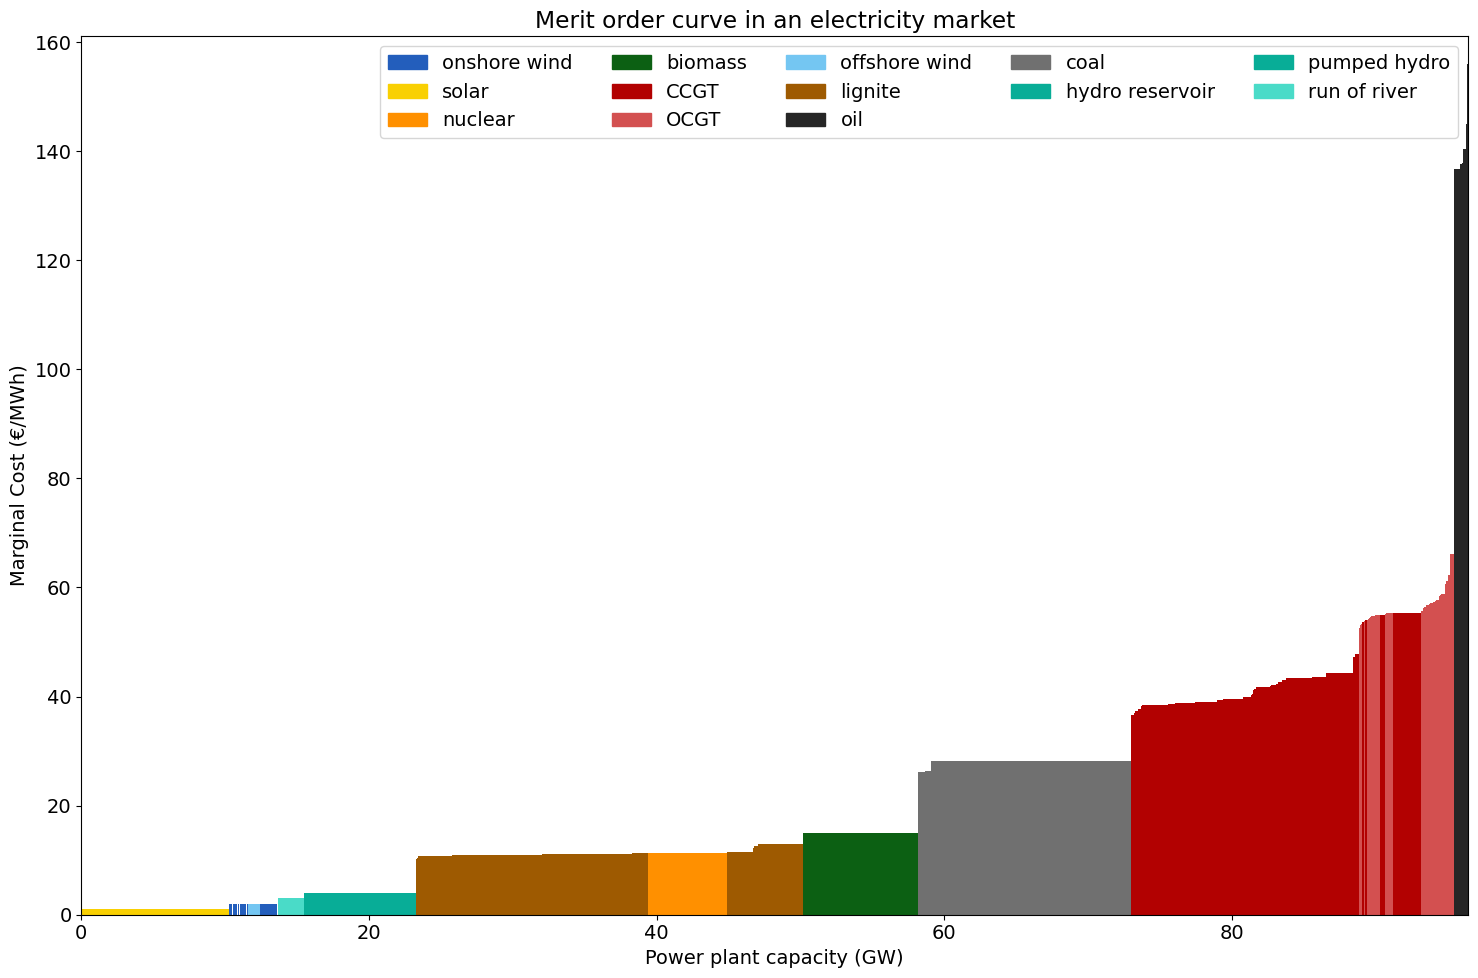

In [9]:
# Plotting using Marginal costs
merit_order_curve(plant1df, techdf)

#### (ii)

In [16]:
plant2df = plant1df.copy()
plant2df = plant2df.drop(['Cumulative capacity (GW)','xpos'], axis=1)
plant2df = plant2df.rename({'marginal_cost': 'old_marginal_cost'}, axis=1)
plant2df["marginal_cost"] = plant2df['old_marginal_cost'] + ((80 * plant2df['co2_emissions'])/plant2df['efficiency'] )
plant2df = cum_xpos(plant2df)
plant2df.head()

,efficiency,old_marginal_cost,p_nom,carrier,p_max_pu,co2_emissions,Available capacity (MW),Available capacity (GW),marginal_cost,Cumulative capacity (GW),xpos
0,1.0,1.0,85.936909,solar,0.252249,0.0,21.677525,0.021678,1.0,0.021678,0.010839
1,1.0,1.0,324.967191,solar,0.159534,0.0,51.843188,0.051843,1.0,0.073521,0.047599
2,1.0,1.0,241.129750,solar,0.125991,0.0,30.380130,0.030380,1.0,0.103901,0.088711
3,1.0,1.0,278.140497,solar,0.083072,0.0,23.105796,0.023106,1.0,0.127007,0.115454
4,1.0,1.0,283.333907,solar,0.116822,0.0,33.099562,0.033100,1.0,0.160106,0.143556


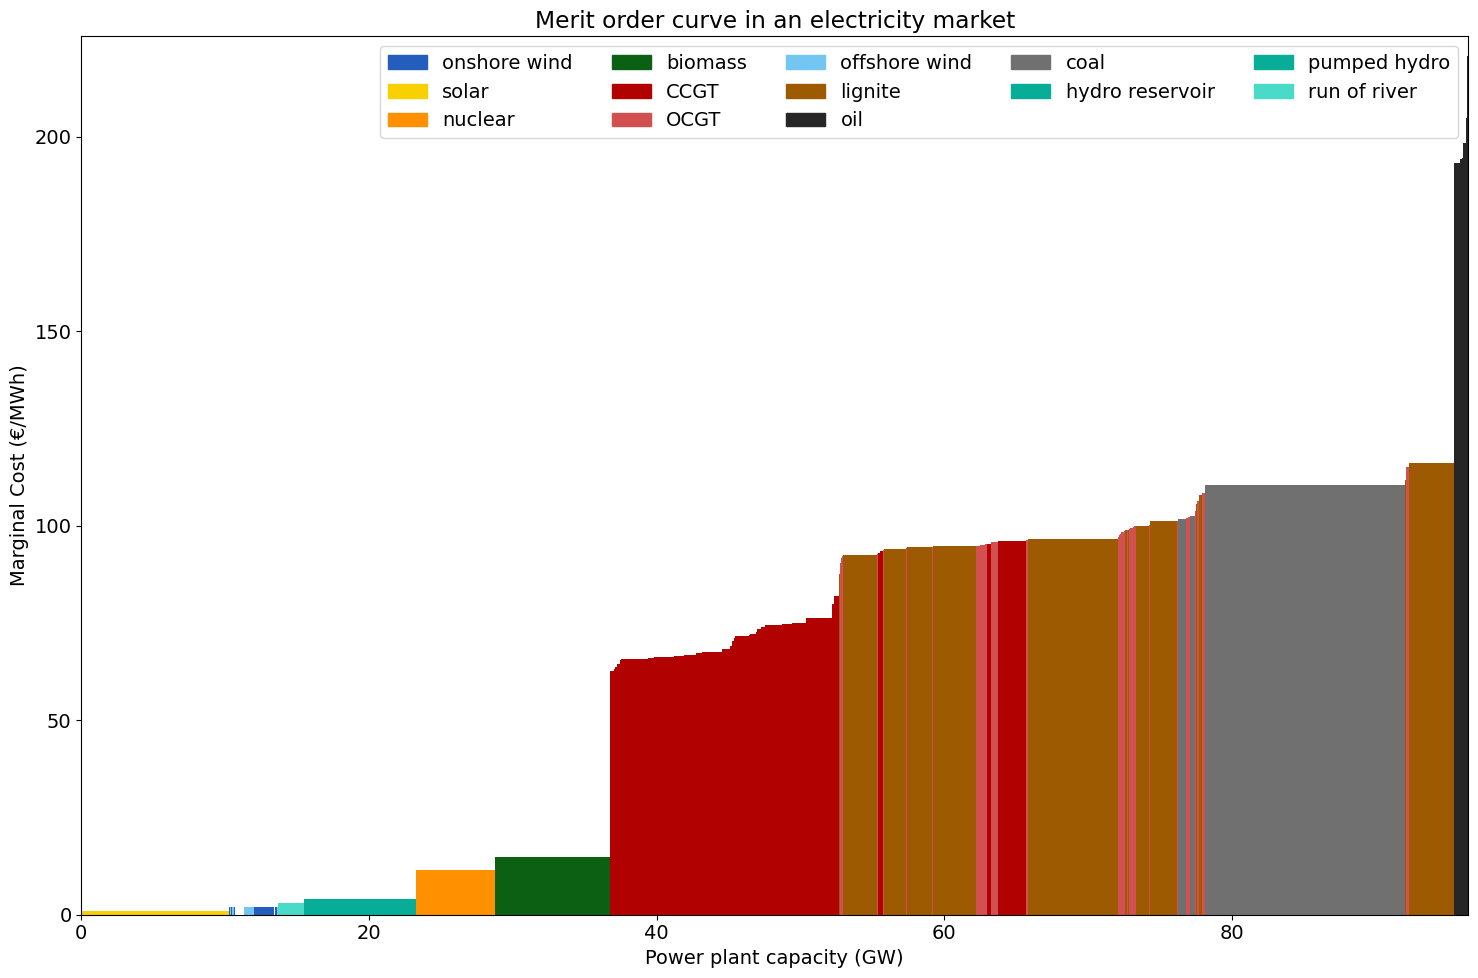

In [11]:
# Plotting using Marginal costs + 80 €/tCO2 carbon price
merit_order_curve(plant2df, techdf)

#### (iii)

In [17]:
plant3df = plant2df.copy()
plant3df = plant3df.drop(['old_marginal_cost','Cumulative capacity (GW)','xpos'], axis=1)
plant3df = plant3df.rename({'marginal_cost': 'old_marginal_cost'}, axis=1)
plant3df['Fuel Price'] = 0
plant3df.loc[plant3df.carrier == 'CCGT', ['Fuel Price']] = 50
plant3df.loc[plant3df.carrier == 'OCGT', ['Fuel Price']] = 50
plant3df['marginal_cost'] = (plant3df['Fuel Price']/plant3df['efficiency']) + plant3df['old_marginal_cost']
plant3df = cum_xpos(plant3df)
plant3df.head()

,efficiency,p_nom,carrier,p_max_pu,co2_emissions,Available capacity (MW),Available capacity (GW),old_marginal_cost,Fuel Price,marginal_cost,Cumulative capacity (GW),xpos
0,1.0,85.936909,solar,0.252249,0.0,21.677525,0.021678,1.0,0,1.0,0.021678,0.010839
1,1.0,62.272999,solar,0.178047,0.0,11.087528,0.011088,1.0,0,1.0,0.032765,0.027221
2,1.0,162.759941,solar,0.197975,0.0,32.222459,0.032222,1.0,0,1.0,0.064988,0.048876
3,1.0,54.795521,solar,0.286393,0.0,15.693060,0.015693,1.0,0,1.0,0.080681,0.072834
4,1.0,28.212425,solar,0.583309,0.0,16.456573,0.016457,1.0,0,1.0,0.097137,0.088909


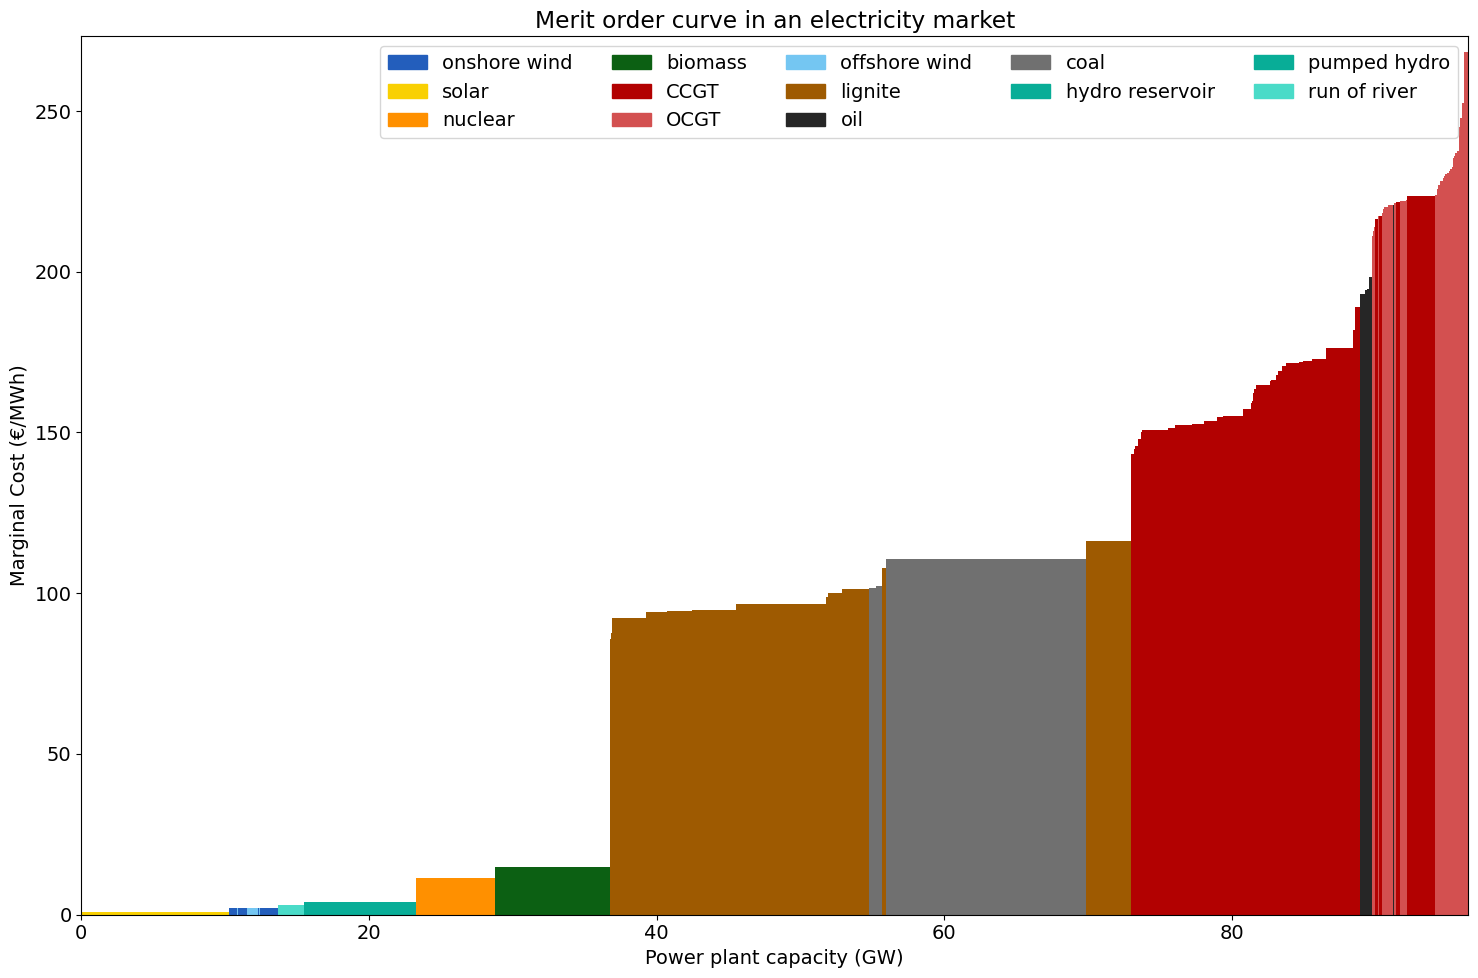

In [13]:
# Plotting using Marginal costs + 80 €/tCO2 carbon price + Gas price increase of 50 €/MWh𝑡ℎ
merit_order_curve(plant3df, techdf)

#### (iv)

In [18]:
plant4df = plant3df.copy()
tech4df = techdf.copy()
plant4df.drop(plant4df.loc[plant4df['carrier']=='nuclear'].index, inplace=True)
tech4df.drop(tech4df.loc[tech4df['carrier']=='nuclear'].index, inplace=True)
plant4df = plant4df.sort_values(by=['marginal_cost'], ascending=True)
plant4df = cum_xpos(plant4df)
plant4df.head()

,efficiency,p_nom,carrier,p_max_pu,co2_emissions,Available capacity (MW),Available capacity (GW),old_marginal_cost,Fuel Price,marginal_cost,Cumulative capacity (GW),xpos
0,1.0,85.936909,solar,0.252249,0.0,21.677525,0.021678,1.0,0,1.0,0.021678,0.010839
1,1.0,62.272999,solar,0.178047,0.0,11.087528,0.011088,1.0,0,1.0,0.032765,0.027221
2,1.0,162.759941,solar,0.197975,0.0,32.222459,0.032222,1.0,0,1.0,0.064988,0.048876
3,1.0,54.795521,solar,0.286393,0.0,15.693060,0.015693,1.0,0,1.0,0.080681,0.072834
4,1.0,28.212425,solar,0.583309,0.0,16.456573,0.016457,1.0,0,1.0,0.097137,0.088909


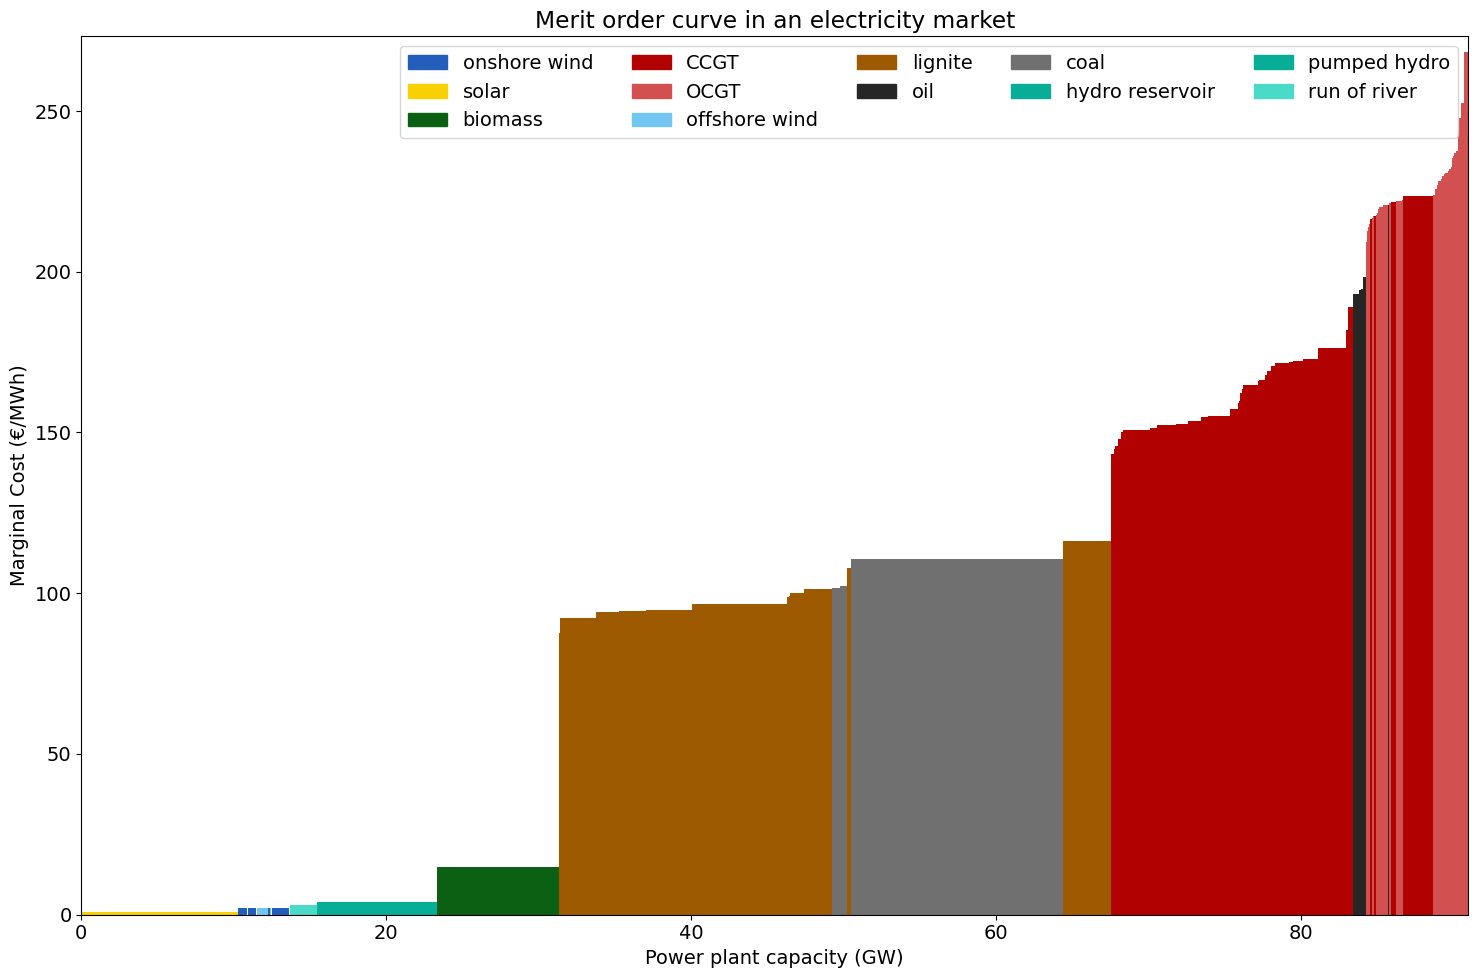

In [15]:
# Plotting using Marginal costs + 80 €/tCO2 carbon price + Gas price increase of 50 €/MWh𝑡ℎ + no nuclear powerplants
merit_order_curve(plant4df, tech4df)

### (e)

Creating another function to do the analysis at Demand = 70 GW

In [21]:
def cut_off(powerdf):
    demand = 70 #GW
    #To get the cutoff power plant

    powerdf = powerdf.sort_index(ascending=True)
    powerdf = powerdf.sort_values(by=['marginal_cost'], ascending=True)
    powerdf["Cumulative capacity (GW)"] = powerdf["Available capacity (GW)"].cumsum()

    for index in powerdf.index:

        if powerdf.loc[index, "Cumulative capacity (GW)"] < demand:
            pass

        else:
            cut_off_power_plant = index
            powerdf = powerdf.loc[:cut_off_power_plant]
            cut_off_carrier = powerdf.loc[cut_off_power_plant, 'carrier']
            mcp = powerdf.loc[cut_off_power_plant, 'marginal_cost']
            powerdf['revenue'] = powerdf['Available capacity (GW)'] * 1000 * mcp
            powerdf['costs'] = powerdf['marginal_cost'] * powerdf['Available capacity (GW)'] * 1000
            powerdf['profit'] = powerdf['revenue'] - powerdf['costs']
            powerdf['carbon_intensity'] = powerdf['co2_emissions'] * (powerdf['Available capacity (GW)'] / powerdf['efficiency']) * 1000
            carbon_sum = powerdf['carbon_intensity'].sum()/70 # Calculating carbon intensity in g/Kwh
            testdf = powerdf.groupby(['carrier']).agg(
                Power_Dispatched_GW = ('Available capacity (GW)','sum'),
                Revenue_Euros = ('revenue','sum'),
                Cost_Euros = ('costs','sum'),
                Profit_Euros = ('profit','sum'),
            )
            testdf = testdf.sort_values(by=['Power_Dispatched_GW'], ascending=False)
            print('The market clearing price is %.2f €/MWh and the carrier is %s ' % (mcp, cut_off_carrier))
            print('The total carbon intensity for this system is %.2f g/kWh' % carbon_sum)
            break
    return testdf

#### (i)

In [22]:
cut_off(plant1df)

The market clearing price is 28.20 €/MWh and the carrier is coal 
The total carbon intensity for this system is 525.07 g/kWh


,Power_Dispatched_GW,Revenue_Euros,Cost_Euros,Profit_Euros
carrier,,,,
lignite,21.375403,602721.598180,242876.813699,359844.784481
coal,12.989911,366276.120045,364435.036908,1841.083137
solar,10.266929,289496.280495,10266.928809,279229.351687
biomass,8.004648,225706.812185,119218.159111,106488.653074
pumped hydro,7.659620,215978.073030,30638.480000,185339.593030
nuclear,5.468000,154181.030303,62219.212121,91961.818182
onshore wind,2.561602,72229.424355,5123.204737,67106.219618
run of river,1.777275,50113.779314,5331.826064,44781.953251
offshore wind,0.861509,24291.946369,1723.018227,22568.928142


#### (ii)

In [23]:
cut_off(plant2df)

The market clearing price is 96.72 €/MWh and the carrier is lignite 
The total carbon intensity for this system is 339.72 g/kWh


,Power_Dispatched_GW,Revenue_Euros,Cost_Euros,Profit_Euros
carrier,,,,
CCGT,18.468029,1.786265e+06,1.364160e+06,422105.251680
lignite,14.970279,1.447956e+06,1.423329e+06,24626.151822
solar,10.266929,9.930381e+05,1.026693e+04,982771.202587
biomass,8.004648,7.742257e+05,1.192182e+05,655007.577509
pumped hydro,7.659620,7.408539e+05,3.063848e+04,710215.467061
nuclear,5.468000,5.288760e+05,6.221921e+04,466656.813390
onshore wind,2.561602,2.477634e+05,5.123205e+03,242640.160204
OCGT,1.840496,1.780165e+05,1.745128e+05,3503.693283
run of river,1.777275,1.719017e+05,5.331826e+03,166569.842871


#### (iii)

In [24]:
cut_off(plant3df)

The market clearing price is 116.11 €/MWh and the carrier is lignite 
The total carbon intensity for this system is 552.15 g/kWh


,Power_Dispatched_GW,Revenue_Euros,Cost_Euros,Profit_Euros
carrier,,,,
lignite,21.375403,2.481880e+06,2.118899e+06,3.629811e+05
coal,14.829727,1.721867e+06,1.632306e+06,8.956146e+04
solar,10.266929,1.192084e+06,1.026693e+04,1.181817e+06
biomass,8.004648,9.294129e+05,1.192182e+05,8.101947e+05
pumped hydro,7.659620,8.893520e+05,3.063848e+04,8.587135e+05
nuclear,5.468000,6.348848e+05,6.221921e+04,5.726656e+05
onshore wind,2.561602,2.974255e+05,5.123205e+03,2.923023e+05
run of river,1.777275,2.063579e+05,5.331826e+03,2.010261e+05
offshore wind,0.861509,1.000291e+05,1.723018e+03,9.830607e+04


#### (iv)

In [25]:
cut_off(plant4df)

The market clearing price is 150.93 €/MWh and the carrier is CCGT 
The total carbon intensity for this system is 564.71 g/kWh


,Power_Dispatched_GW,Revenue_Euros,Cost_Euros,Profit_Euros
carrier,,,,
lignite,21.375403,3.226178e+06,2.118899e+06,1.107279e+06
coal,14.829727,2.238243e+06,1.632306e+06,6.059371e+05
solar,10.266929,1.549582e+06,1.026693e+04,1.539315e+06
biomass,8.004648,1.208137e+06,1.192182e+05,1.088919e+06
pumped hydro,7.659620,1.156062e+06,3.063848e+04,1.125424e+06
CCGT,2.605500,3.932467e+05,3.894577e+05,3.789033e+03
onshore wind,2.561602,3.866213e+05,5.123205e+03,3.814980e+05
run of river,1.777275,2.682432e+05,5.331826e+03,2.629114e+05
offshore wind,0.861509,1.300271e+05,1.723018e+03,1.283041e+05


### (f)

Case 1: Here we consider the general marginal cost for each powerplant/carrier.
In this case we can see that our demand can be met by operating the power plants with lower marginal costs, which gives us the lowest market clearing price out of all other cases as we do not consider any other factor except the costs, even though the carbon intensity of this system is very high

Case 2: Here we consider general marginal cost + carbon price of  80 €/tCO2.
In this case we can see that our market clearing price is quite high since we have also added costs for carbon emissions, however by incorporating this carbon price, the carbon intensity of our system is the lowest among all other cases.

Case 3: Here we consider general marginal cost + carbon price of  80 €/tCO2 + Gas price increase of 50 €/MWhth.
Due to CCGT/OCGT now being expensive to operate due to increase in price. We have to use more coal powerplants to meet the demand. This has caused a further increase in the market clearing price and also increased the carbon intensity of the system in order to substitue the CCGT/OCGT plants not being used.

Case 4: Here we consider general marginal cost + carbon price of  80 €/tCO2 + Gas price increase of 50 €/MWhth + no nuclear.
Since we cannot use nuclear now which was a zero emission carrier, we now have to substitute it with CCGT and other high emission sources which has caused a further increase in market clearing price and carbon intensity of the system. In this case we have the most expensive and the most polluting system.
